# Misc

In [2]:
using IJulia
using DifferentialEquations
using DynamicalSystems
using Plots, DataFrames

function load_cnf(file_name)
    c = Nothing
    open(file_name) do file
        for (idx, line) in enumerate(eachline(file))
            if idx == 1
                N = parse(Int32, split(line, " ")[3])
                M = parse(Int32, split(line, " ")[4])
                c = zeros(M,N)
            else
                variables = split(line, " ")
                for var_str in variables
                    var = parse(Int32, var_str)
                    if var != 0
                        if var > 0
                            c[idx-1, var] = 1
                        elseif var < 0
                            c[idx-1, -var] = -1
                        end
                    end
                end
            end
        end
    end
    return c
end

function number_of_satisfied_clauses(state, c)
    M, N = size(c)
    result = 0
    for m in 1:M
        satisfied = 0
        for j in 1:N
            if c[m,j] == state[j]
                satisfied = 1
                break
            end
        end
        result += satisfied
    end
    return result
end

function is_satisfied(spin_config, c)
    function check_clause(row, state)
        for (index,elem) in enumerate(row)
            if elem == state[index]
                return true
            end
        end
    end

    incorrect_flag = false
    for clause in eachrow(c)
        if check_clause(clause, spin_config) != true
            incorrect_flag = true
            break
        end
    end

    if incorrect_flag
        return false
    end
    return true
end

function read_Ising_data(file_path)
    # Initialize variables
    result_vector = []
    matrix = []

    # Open the file and read its contents
    file = open(file_path, "r")
    contents = readlines(file)

    # Extract the result vector from the third line
    result_vector_str = contents[3]
    # Remove the brackets and split the string into individual elements
    result_vector_str = replace(result_vector_str, r"[\[\]]" => "")
    result_vector_str = split(result_vector_str, ",")

    # Convert the elements to floats and store them in the result vector
    for num_str in result_vector_str
        push!(result_vector, parse(Float64, num_str))
    end

    # Determine the size of the matrix
    N = length(result_vector)

    # Initialize the matrix with zeros
    matrix = zeros(Float64, N, N)

    # Extract the matrix from the lines after the fifth line
    for i in 6:length(contents)
        line = contents[i]
        # Skip empty lines
        if line != "\n" && line != "[\n" && line != "]\n"
            # Remove the brackets and split the string into individual rows
            line = replace(line, "[" => "")
            line = replace(line, "]," => "")
            line = replace(line, "]" => "")
            # Convert the elements to floats and store them in the matrix
            row_str = split(line, ",")
            if row_str != [""]
                row = [parse(Float64, num_str) for num_str in row_str]
                matrix[i-5, :] = row
            end
        end
    end

    # Close the file
    close(file)

    return (N, result_vector, matrix)
end


read_Ising_data (generic function with 1 method)

# Regular CAC

## The update rule

$$
\frac{dx_i}{dt} = (p-1)x_i -x_i^3 -e_i \sum_j J_{ij}x_j
$$

$$
\frac{de_i}{dt} = - \beta e_i \left( x_i^2 - \alpha \right)
$$

In [5]:
function CIMCAC_rule!(du, u, params, t)
    p = params[1]
    beta = params[2]
    alpha = params[3]
    N = params[4]
    J = params[5]

    x = u[1:N]
    e = u[N+1:2N]

    for i in 1:N
        du[i] = (p-1)*x[i]-x[i]^3 - e[i] * sum(J[i, j]*x[j] for j in 1:N)
        du[i+N] = -beta*e[i]*(x[i]^2 - alpha)
    end
end

CIMCAC_rule! (generic function with 1 method)

# Algo 2

## The update rule

### EoM:
$$
\frac{dx_i}{dt} = a F(x_i) - e_i h_i
$$

$$
\frac{de_i}{dt} = e_i K_i
$$

where
$$K_i = 1-\text{tanh}(h_i) x_i$$

In [ ]:
function F(x_i, p)
    return (p-1)*x_i-x_i^3
end

function ALGO2_rule!(du, u, params, t)
    p = params[1]
    a = params[2]
    b = params[3]
    N = params[4]
    J = params[5]

    x = u[1:N]
    e = u[N+1:2N]

    h = [sum(J[i, j]*x[j] for j in 1:N) for i in 1:N]
    K = [1-tanh(h[i])*x[i] for i in 1:N]


    
    for i in 1:N
        du[i]   = a * F(x[i], p) - e[i] * h[i]
        du[i+N] = e[i]*K[i]
    end
end

ALGO4_rule! (generic function with 1 method)

# Algo 3

## The update rule

### EoM:
$$
\frac{dx_i}{dt} = a F(x_i) - e_i \partial_i \sum_m K_m = a F(x_i) - e_i\left( \frac{K_i-1}{x_i} - h_i \sum_m \frac{1}{\text{ch}^2(h_m)} \right)
$$

$$
\frac{de_i}{dt} = e_i K_i
$$

In [ ]:
function F(x_i, p)
    return (p-1)*x_i-x_i^3
end

function ALGO3_rule!(du, u, params, t)
    p = params[1]
    a = params[2]
    b = params[3]
    N = params[4]
    J = params[5]

    x = u[1:N]
    e = u[N+1:2N]

    h = [sum(J[i, j]*x[j] for j in 1:N) for i in 1:N]

    K = [1-tanh(h[i])*x[i] for i in 1:N]
    K = [1-tanh(h[i]) for i in 1:N]

    K = K - ones(N)*minimum(K)
    K = K*(1/maximum(K))
    sigma_prime = sum( [(1/cosh(h[m]))^2 for m in 1:N] )
    
    for i in 1:N
        du[i]   = e[i] * (a * F(x[i], p) - ((K[i]-1)/(x[i]) - h[i] * sigma_prime) )
        du[i+N] = e[i]*K[i]
    end
end

ALGO3_rule! (generic function with 1 method)

### Derivation

where
$$h_i = \sum_j J_{ij}x_j$$
and
$$K_i = 1-\sigma(h_i) x_i$$
and
$$
F(x_i) = (p-1)x_i -x_i^3
$$

$$
\partial_i K_m = \underbrace{- \sigma\left( h_m \right)}_{-\frac{1-K_m}{x_m}} \overbrace{\partial_i x_m}^{= \delta_{im}} - x_m \partial_i \sigma \left( h_m \right)
$$
$$
\partial_i K_m = -\delta_{im} \frac{1-K_m}{x_m} - x_m \sigma'(h_m)  \underbrace{\partial_i h_m}_{=\sum_j J_{mj} \delta_{ij}}
$$
if $\sigma \equiv \text{tanh}$ we have 
$$
\partial_i K_m = -\delta_{im} \frac{1-K_m}{x_m} - \frac{x_m}{\text{ch}^2(h_m)} J_{mi} 
$$
For the sum
$$
\sum_m \partial_i K_m = \frac{K_i-1}{x_i} + h_i \sum_m - \sigma'(h_m)
$$

# Algo 4

## The update rule

### EoM:
$$
\frac{dx_i}{dt} = a F(x_i) - e_i \partial_i \sum_m K_m = a F(x_i) - e_i\left( \sum_m \frac{J_{mi}}{h_m^{\text{max}} - h_m^{\text{min}}} \right)
$$

$$
\frac{de_i}{dt} = e_i K_i
$$

In [ ]:
function F(x_i, p)
    return (p-1)*x_i-x_i^3
end

function boxed(x)
    N = length(x)
    result = zeros(N)
    for i in 1:N
        if x[i] > 1.0
            result[i] = 1.0
        elseif x[i] < -1.0
            result[i] = -1.0
        else
            result[i] = x[i]
        end
    end
    return result
end

function ALGO4_rule!(du, u, params, t)
    p = params[1]
    a = params[2]
    b = params[3]
    N = params[4]
    J = params[5]

    x = u[1:N]
    x = boxed(x)
    e = u[N+1:2N]

    h = [sum(J[i, j]*x[j] for j in 1:N) for i in 1:N]
    h_min = [sum(- J[i, j] for j in 1:N) for i in 1:N]
    h_max = [sum(J[i, j] for j in 1:N) for i in 1:N]

    K = [(h[i]-h_min[i])/(h_max[i]-h_min[i]) for i in 1:N]

    for i in 1:N
        du[i]   = a * F(x[i], p) - e[i] * h[i]*sum( J[m, i]/(h_max[m]-h_min[m]) for m in 1:N) 
        du[i+N] = e[i]*K[i]
    end
end

ALGO4_rule! (generic function with 1 method)

### Derivation

where
$$h_i = \sum_j J_{ij}x_j$$
and
$$K_m = \frac{h_m - h_m^{\text{min}}}{h_m^{\text{max}} - h_m^{\text{min}}}$$
and
$$
F(x_i) = (p-1)x_i -x_i^3
$$

For the sum
$$
\partial_i \sum_m K_m = \sum_m \frac{1}{h_m^{\text{max}} - h_m^{\text{min}}} \underbrace{\sum_j J_{mj} \delta_{ij}}_{=\partial_i h_m}= \sum_m \frac{J_{mi}}{h_m^{\text{max}} - h_m^{\text{min}}}
$$

# Simulation Code

In [3]:
file_path = "ISING_problems/genport_1.dat"
(N, B, J) = read_Ising_data(file_path);

In [6]:
# define problem and run simulation
params = (1.05, 0.5, 1.0, N, J)
tspan = (0.0,15.0)

# initial condition(s)
u0 = 0.95*(2*rand(2*N)-ones(2*N))
u0[N+1:2*N] = ones(N);

#p, beta, alpha, N J
prob = ODEProblem(CIMCAC_rule!, u0, tspan, params)
sol = solve(prob, Tsit5());

# Plotting

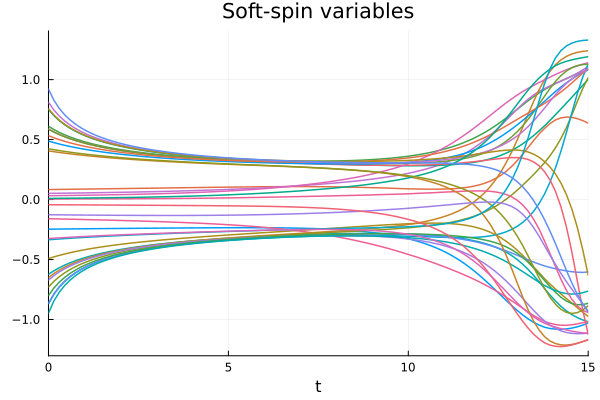

In [7]:
plot(sol, idxs=1:N, plotdensity=100, lw=1.5, title="Soft-spin variables", legend=false)

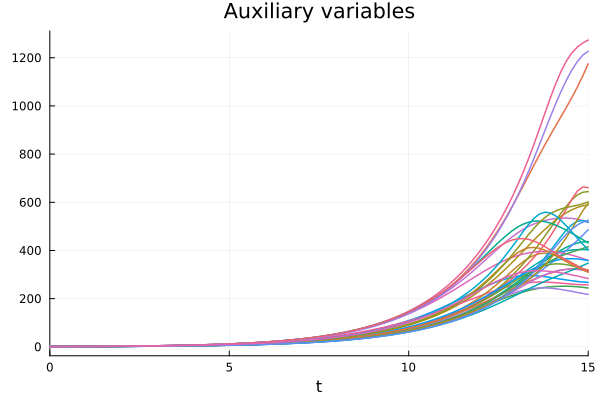

In [8]:
plot(sol, idxs=(N+1):2N, plotdensity=100, lw=1.5, title="Auxiliary variables", legend=false)

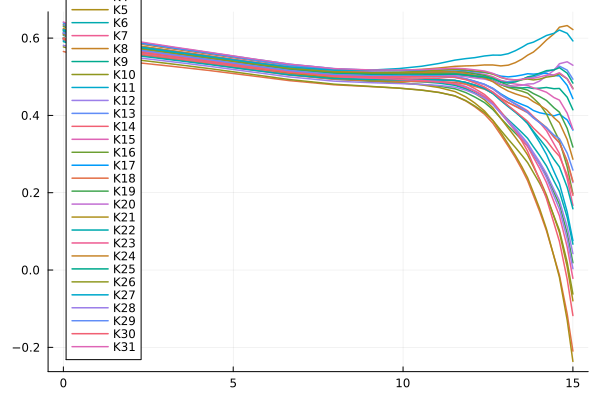

In [140]:
# Preallocate the array for K
K_values = zeros(length(sol.t), N)

# Compute K for each time instance
for (i, u) in enumerate(sol.u)
    x = u[1:N]
    h = [sum(J[i, j] * x[j] for j in 1:N) for i in 1:N]
    h_min = [sum(- J[i, j] for j in 1:N) for i in 1:N]
    h_max = [sum(J[i, j] for j in 1:N) for i in 1:N]

    # K first kind
    #K = [1 - tanh(h[i]) * x[i] for i in 1:N]
    #K = [1 - tanh(h[i]) for i in 1:N]
    #K = K - ones(N)*minimum(K)
    #K = K*(1/maximum(K))
    
    # K second kind
    K = [(h[i]-h_min[i])/(h_max[i]-h_min[i]) for i in 1:N]
    K_values[i, :] = K
end

# Plot each component of K over time
p = plot()
for i in 1:N
    plot!(p, sol.t, K_values[:, i], label="K$i", lw=1.5)
end

# Show the plot
display(p)